###setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import thunder
from showit import image, tile
import matplotlib.animation as animation

In [4]:
from os.path import join, exists
from os import mkdir, makedirs
import pandas as pd

In [5]:
import regression

###set directory and session information

In [6]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [7]:
key = '2016-03-16'
name = 'anm-0350549'

In [8]:
path = join(directory, 'processed', name, key)

In [9]:
pixelsPerUm = 600.0/512
frameRate = 9.66
scaleBar = 100

###load covariates

In [10]:
covariates = pd.read_csv(join(path, 'behavior','covariates.csv'))

###load data

In [11]:
data = thunder.images.frombinary(join(path, 'registered'), engine=sc)

In [12]:
data.cache()

Images
mode: spark
dtype: int16
shape: (8848, 512, 512, 4)

In [13]:
records = data.toseries()

In [14]:
avg = data.map(lambda x: x.mean(axis=0).mean(axis=0)).toseries().toarray()

In [15]:
avg.shape

(4, 8848)

In [16]:
covariates.shape

(8848, 26)

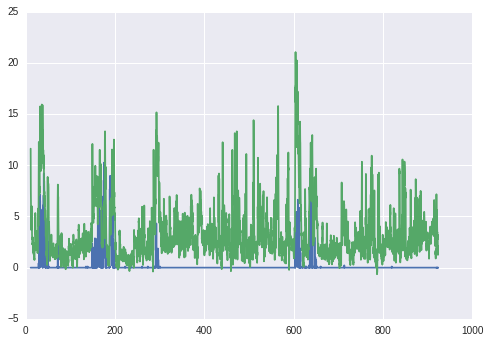

In [17]:
plt.plot(covariates.allTime, covariates.speed);
plt.plot(covariates.allTime, avg[1]/10-40);

###Difference maps

In [16]:
results = data.gaussian_filter((1, 1, 0))

In [20]:
from numpy import where

In [22]:
runningInds = covariates.speed > 1

In [29]:
running = results[where(runningInds.values)].mean().toarray()

In [30]:
still = results[where(~runningInds.values)].mean().toarray()

In [31]:
movie = running - still

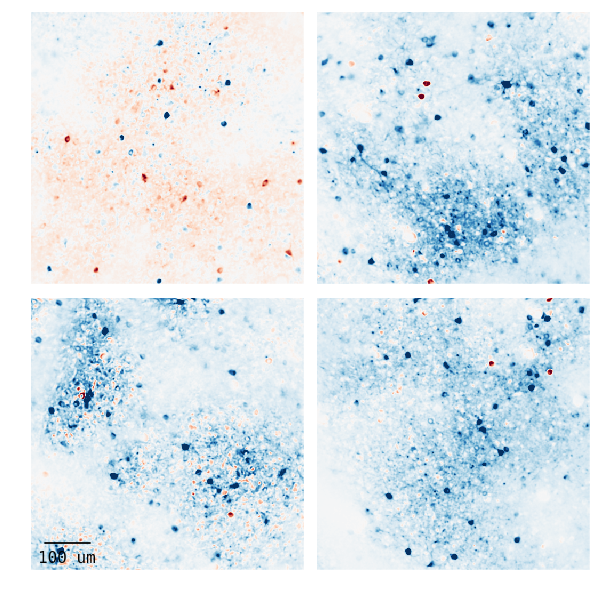

In [33]:
fig = plt.figure(figsize=[10,10])
axes, g = tile(movie, cmap='RdBu', clim=[(-300, 300), (-300, 300), (-300, 300), (-300, 300)], axis=2, fig=fig)

frame = 0
g[2].plot([.05*movie.shape[1], .05*movie.shape[1]+100/pixelsPerUm], [.9*movie.shape[0], .9*movie.shape[0]], 'k');
g[2].text(.05*movie.shape[1]+100/pixelsPerUm/2, .975*movie.shape[1], '100 um', color='black', fontsize=16, ha='center', fontdict={'family': 'monospace'});
for i in range(4):
    g[i].set_xlim([0, movie.shape[1]]);
    g[i].set_ylim([movie.shape[0], 0]);

##Pixelwise regression demo

In [19]:
from regression import LinearRegression
algorithm = LinearRegression(fit_intercept=False)

In [20]:
X = covariates.speed.values

In [21]:
import numpy as np

In [22]:
def buildReg(X,scale):
    maxVal = np.floor(max(X)/scale)*scale
    minVal = np.ceil(min(X)/scale)*scale
    edges = np.arange(minVal,maxVal,scale)
    edges = np.concatenate((edges, [np.Inf]))
    regMat = np.zeros([edges.shape[0]-1,X.shape[0]])
    for iEdge in range(0, edges.shape[0]-1):
        regMat[iEdge,:] = (X >= edges[iEdge]) & (X < edges[iEdge+1])
    edges = edges[:-1]
    return edges, regMat.transpose()

In [23]:
edges, regMat = buildReg(X, 2)

In [24]:
regMat.sum(axis=0)

array([ 8541.,   135.,    93.,    57.,    22.])

In [25]:
records = records.astype('float64')

In [26]:
model, rsq = algorithm.fit_and_score(regMat, records)

In [27]:
def tuning(x):
    return sum(x[1:]*edges)/sum(x[1:])

In [28]:
tune = model.betas.map(tuning)

In [30]:
tune

Series
mode: spark
dtype: float64
shape: (512, 512, 4, 1)

In [29]:
tuneA = tune.toarray()

In [31]:
rsqA = rsq.toarray()

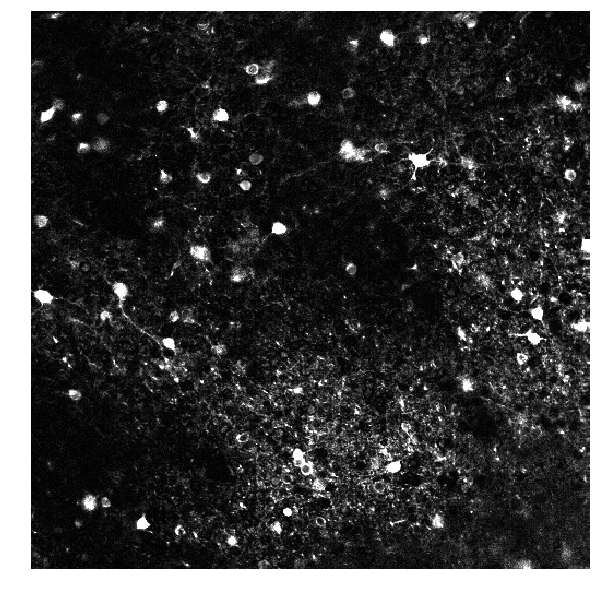

In [34]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(rsqA[:,:,1], clim=(0, .025), ax=ax)

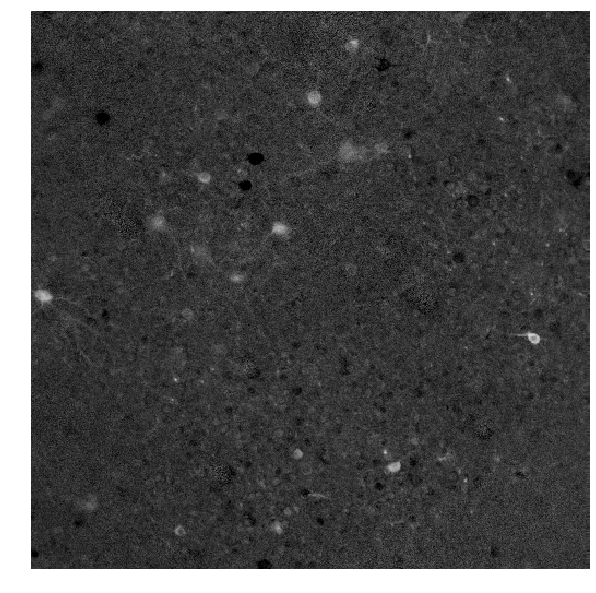

In [48]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(tuneA[:,:,1], clim=(3.5, 6), ax=ax)

In [ ]:
img = Colorize(cmap='rainbow', scale=1, vmin=0, vmax=30).transform(tune,background=imgC.clip(min=0, max=500),mask=rsq.clip(min=0,max=0.1),mixing=.8)

In [50]:
import showit

ImportError: No module named Colorize

In [85]:
betasA[:,:,:,0].max()

0.0

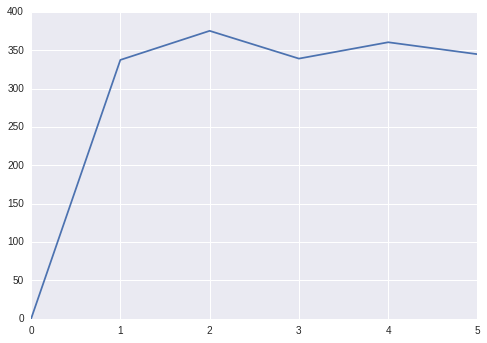

In [84]:
plt.plot(betasA[123,10,1,:])

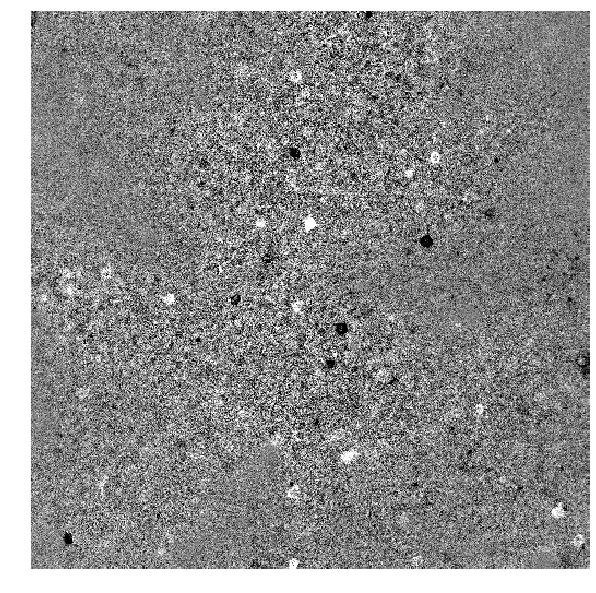

In [77]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(betasA[:,:,0,2] - betasA[:,:,0,5], clim=(-125, 125), ax=ax)

In [183]:
series = thunder.images.fromrandom((10, 2, 2), engine=sc).toseries()
X = np.random.randn(10, 3)

model, rsq = regression.LinearRegression(fit_intercept=False).fit_with_score(X, series)

model.betas #returns Series with shape (2, 2, 4)
rsq #returns Series with shape (2, 2, 1)

AttributeError: 'Series' object has no attribute 'betas'

In [182]:
regression.LinearRegression.fit_with_score

<unbound method LinearRegression.fit_with_score>

In [15]:
from thunderRegression import LinearRegression
from thunderRegression import TuningModel

In [16]:
reg = LinearRegression('ordinary', intercept=False)

In [8]:
y = thunder.series.fromrandom(shape=(10, 100), npartitions=1, seed=42, engine=sc)

In [9]:
from numpy.random import rand

In [10]:
Z = rand(100,3) # 3 regressors each with 100 timepoints => (100,3)
v = rand(100)

In [17]:
y = data.toseries()

In [18]:
Z = covariates.speed.values

In [19]:
import numpy as np

In [21]:
edges, regMat = buildReg(Z, 1)

In [22]:
regMat.sum(axis = 1)

array([  8.41700000e+03,   1.24000000e+02,   7.10000000e+01,
         6.40000000e+01,   4.60000000e+01,   4.70000000e+01,
         3.40000000e+01,   2.30000000e+01,   1.90000000e+01,
         3.00000000e+00])

In [23]:
results = reg.fit(regMat.T, y)

In [24]:
betas = results.coeffs

In [25]:
from thunder.series import fromrdd

In [176]:
betas

Series
mode: spark
dtype: float64
shape: (512, 512, 4, 6)

In [177]:
rsq

Series
mode: spark
dtype: float64
shape: (1048576, 1)

In [27]:
rsq = fromrdd(results._stats, shape = (1048576,), index = range(1048576))

In [28]:
t = TuningModel.load(edges,'gaussian')

In [29]:
tune = t.fit(betas).select('center')

In [66]:
XX = betas[:,0].toarray()

In [62]:
zzz = XX.reshape((512, 512, 4), order='C')

In [175]:
records

Series
mode: spark
dtype: float64
shape: (512, 512, 4, 8848)

In [57]:
XX.reshape?

In [128]:
movie = betas[:,0].toarray().reshape(4,512,512)

In [133]:
movie = movie.swapaxes(1,2)

In [112]:
xxx = tune.toarray().reshape(512,512,4)

In [63]:
movie = zzz

In [64]:
print movie.min()
print movie.max()

2.95710494927
6.65776183853


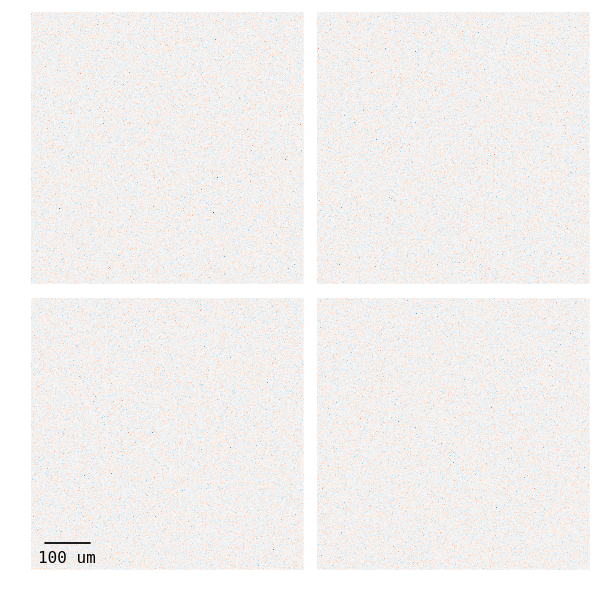

In [65]:
fig = plt.figure(figsize=[10,10])
axes, g = tile(movie, cmap='RdBu', clim=[(2, 7), (2, 7), (2, 7), (2, 7)], axis=2, fig=fig)

frame = 0
g[2].plot([.05*movie.shape[1], .05*movie.shape[1]+100/pixelsPerUm], [.9*movie.shape[0], .9*movie.shape[0]], 'k');
g[2].text(.05*movie.shape[1]+100/pixelsPerUm/2, .975*movie.shape[1], '100 um', color='black', fontsize=16, ha='center', fontdict={'family': 'monospace'});
for i in range(4):
    g[i].set_xlim([0, movie.shape[1]]);
    g[i].set_ylim([movie.shape[0], 0]);

In [ ]:
import numpy as np
X = regressors['corridorPosition']
edges = np.arange(0,30,2)

edges = np.concatenate((edges, [np.Inf]))
regMat = np.zeros([edges.shape[0]-1,X.shape[0]])
for n in range(0, edges.shape[0]-1):
    regMat[n,:] = np.logical_and(X >= edges[n], X < edges[n+1])
edges = edges[:-1]
regMat.sum(1)

In [ ]:
from thunder import RegressionModel
results = RegressionModel.load(regMat, 'mean').fit(series)

In [ ]:
betas = results.coeffs
rsq = results.stats.pack()

In [ ]:
from thunder import TuningModel
t = TuningModel.load(edges,'gaussian')
tune = t.fit(betas).select('center').pack()

In [184]:
from thunder import TuningModel

ImportError: cannot import name TuningModel

In [ ]:
from thunder import LinearRegression
from thunder import TuningModel

In [ ]:
def buildReg(X,scale):
    maxVal = np.floor(max(X)/scale)*scale
    minVal = np.ceil(min(X)/scale)*scale
    edges = np.arange(minVal,maxVal,scale)
    edges = np.concatenate((edges, [np.Inf]))
    regMat = np.zeros([edges.shape[0]-1,X.shape[0]])
    for iEdge in range(0, edges.shape[0]-1):
        regMat[iEdge,:] = (X >= edges[iEdge]) & (X < edges[iEdge+1])
    edges = edges[:-1]
    return edges, regMat

In [ ]:
regressorName = 'corPos'
pattern = re.compile('OL_.*R|OL_out')
indexOL = covariates.trialType.str.match(pattern, as_indexer=True)
mask = (covariates.itiPeriod == 0) & indexOL & (covariates.speed > speedThresh)
edges, regMat = buildReg(covariates[regressorName][mask==True].values,3)
results = LinearRegression('ordinary', intercept=False).fit(regMat.T, series.applyValues(lambda v: v[mask.values==True]))
betas = results.coeffs
rsq = results.stats.pack()
t = TuningModel.load(edges,'gaussian')
tune = t.fit(betas).select('center').pack()

In [36]:
results.map

BoltArray
mode: spark
shape: (8848, 512, 512, 4)